![](https://clinicablasi.com/wp-content/uploads/2022/11/98.jpg.webp)

# Introduction 

### Context  
This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

### Content
The datasets consists of several medical predictor variables and one target variable, Outcome. Predictor variables includes the number of pregnancies the patient has had, their BMI, insulin level, age, and so on.

### Acknowledgements
Smith, J.W., Everhart, J.E., Dickson, W.C., Knowler, W.C., & Johannes, R.S. (1988). Using the ADAP learning algorithm to forecast the onset of diabetes mellitus. In Proceedings of the Symposium on Computer Applications and Medical Care (pp. 261--265). IEEE Computer Society Press.

### Inspiration
Can you build a machine learning model to accurately predict whether or not the patients in the dataset have diabetes or not?

# Dataset Story

* Pregnancies: Number of times pregnant
* Glucose Plasma: glucose concentration a 2 hours in an oral glucose tolerance test
* Blood Pressure: Diastolic blood pressure (mm Hg)
* SkinThickness: Triceps skin fold thickness (mm)
* Insulin: 2-Hour serum insulin (mu U/ml)  
* DiabetesPedigreeFunction: Diabetes pedigree function
* BMI: Body mass index (weight in kg/(height in m)^2)
* Age Age: (years) 
* Outcome: Class variable (0 or 1) 268 of 768 are 1, the others are 0

# Necessary Libraries and Settings

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
# !pip install missingno
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
# pd.set_option('display.width', 500)


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/pima-indians-diabetes-database/diabetes.csv


# First touch with the data

In [2]:
df_= pd.read_csv("/kaggle/input/pima-indians-diabetes-database/diabetes.csv")
df = df_.copy()


df.columns = [col.upper() for col in df.columns]
df.head()


,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


In [3]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
    
check_df(df)

##################### Shape #####################
(768, 9)
##################### Types #####################
PREGNANCIES                   int64
GLUCOSE                       int64
BLOODPRESSURE                 int64
SKINTHICKNESS                 int64
INSULIN                       int64
BMI                         float64
DIABETESPEDIGREEFUNCTION    float64
AGE                           int64
OUTCOME                       int64
dtype: object
##################### Head #####################
   PREGNANCIES  GLUCOSE  BLOODPRESSURE  SKINTHICKNESS  INSULIN    BMI  \
0            6      148             72             35        0 33.600   
1            1       85             66             29        0 26.600   
2            8      183             64              0        0 23.300   
3            1       89             66             23       94 28.100   
4            0      137             40             35      168 43.100   

   DIABETESPEDIGREEFUNCTION  AGE  OUTCOME  
0                    

In [4]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)


Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


# Missing Analysis

In [5]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns
missing_values_table(df, True)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


[]

### There are no missing values, However there could be wrong values such as glucose or insulin can't be zero. We have to check for these situations if there is any.

In [6]:
# Glucose
# BloodPressure
# SkinThickness
# Insulin
# BMI :Based on these figures a mean BMI of 12 as the lower limit for human survival emerges - a value first proposed by James et al (1988)
# BMI lower than 12 will also be NaN
# 90/60mmHg or less is considered the lowest blood pressure before death.


df.loc[df["BLOODPRESSURE"]<60, "BLOODPRESSURE"].count()      #121
df.loc[df["BLOODPRESSURE"]<60, "BLOODPRESSURE"] = 0 # I changed all the values under 60 with 0 (since they are wrong values)

df[df["BMI"]<12]['BMI'].count() #11
df.loc[df["BMI"]<12,"BMI"] = 0


for col in [col for col in num_cols if col not in "PREGNANCIES"]:
     df[col].replace(0, np.nan, inplace=True)


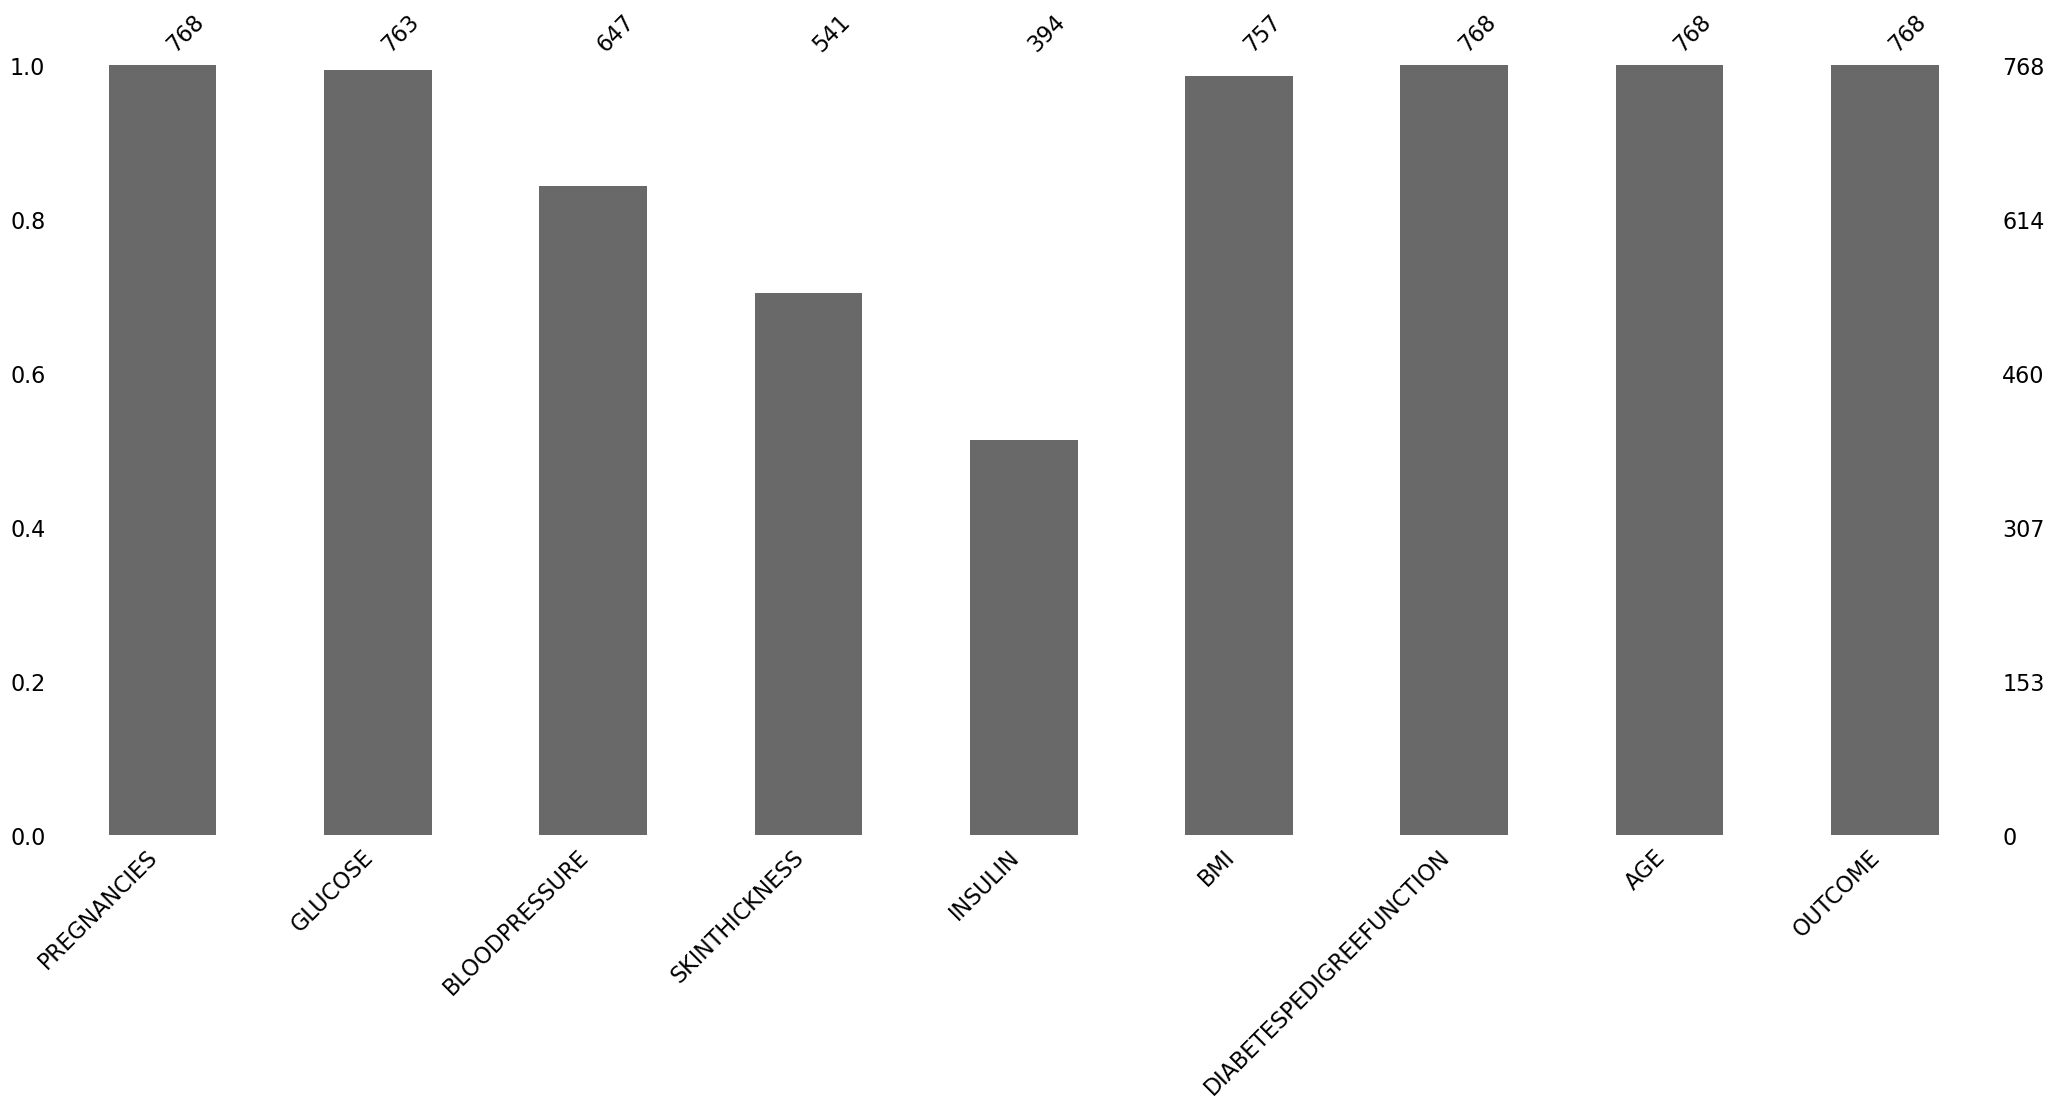

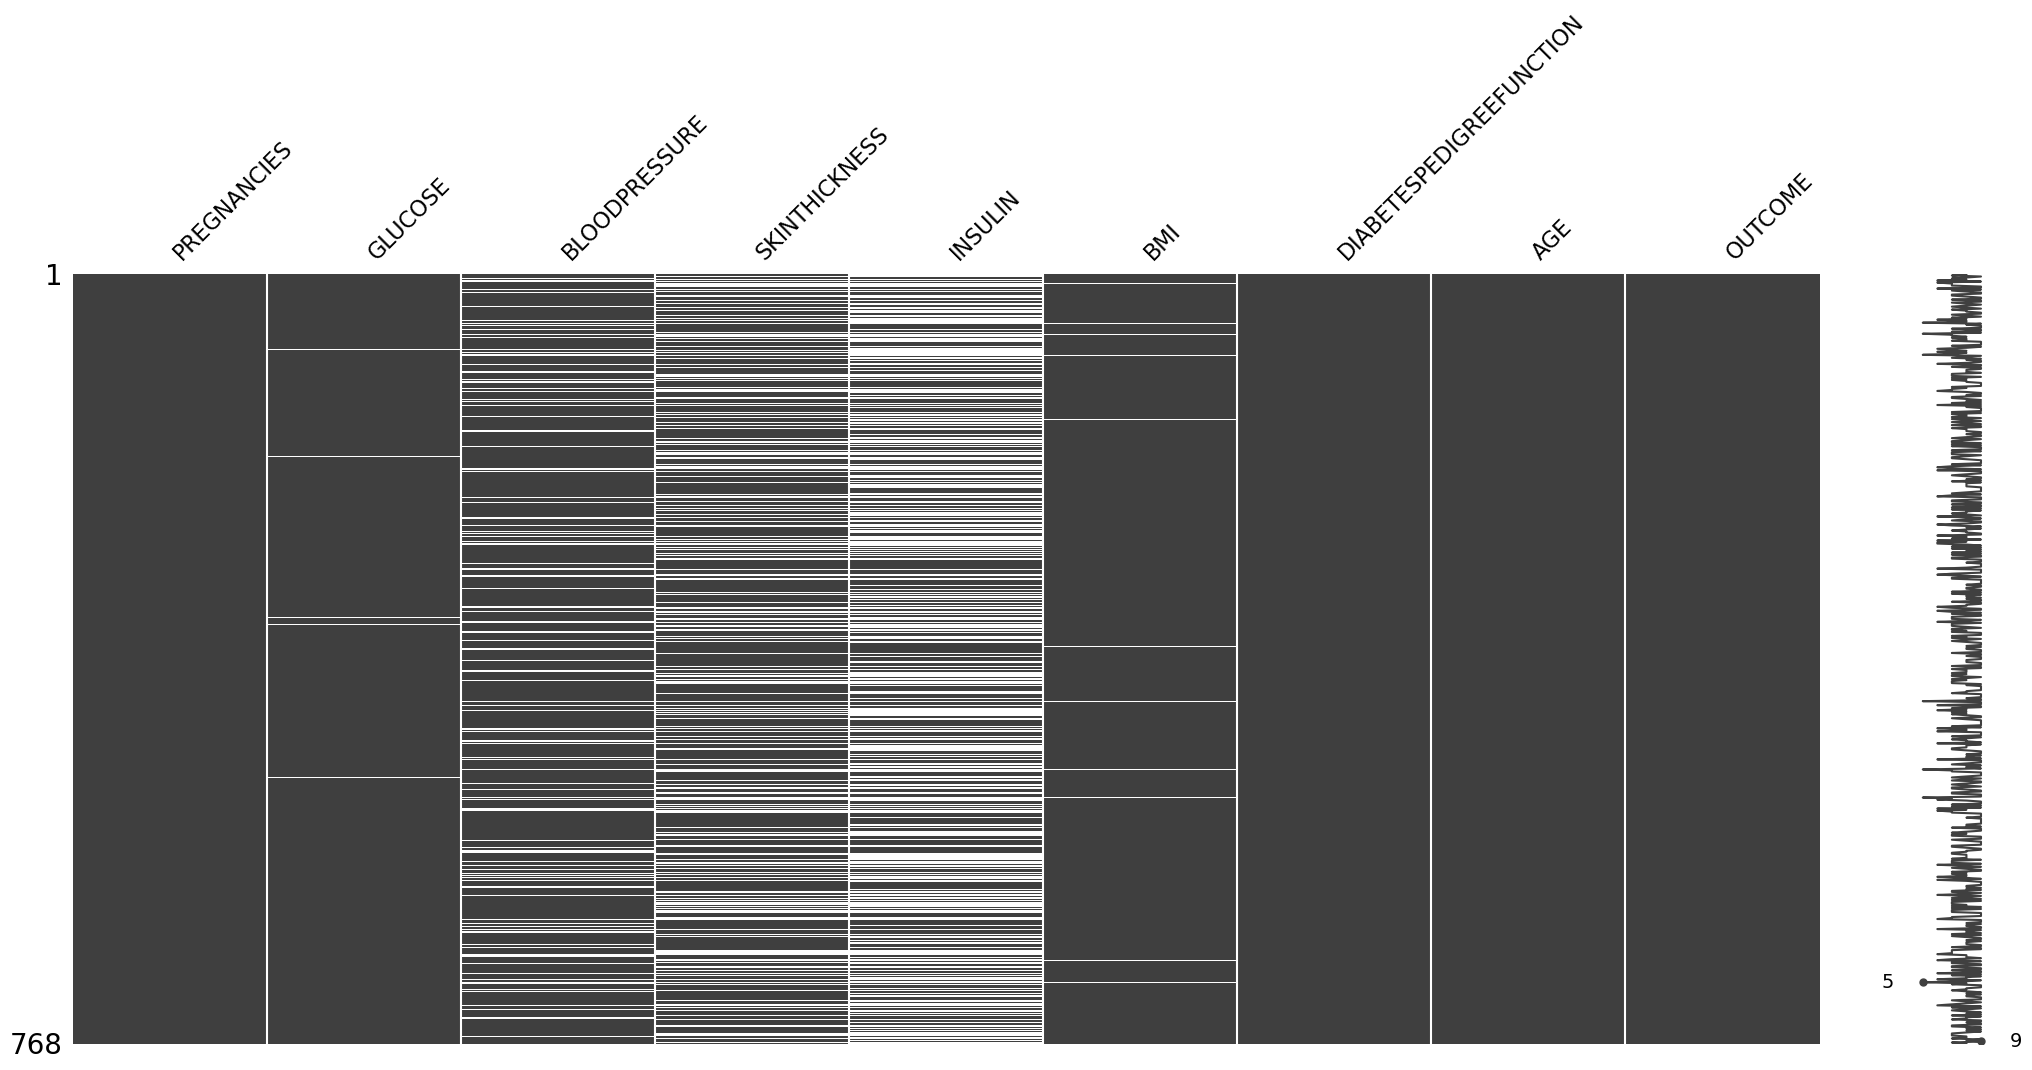

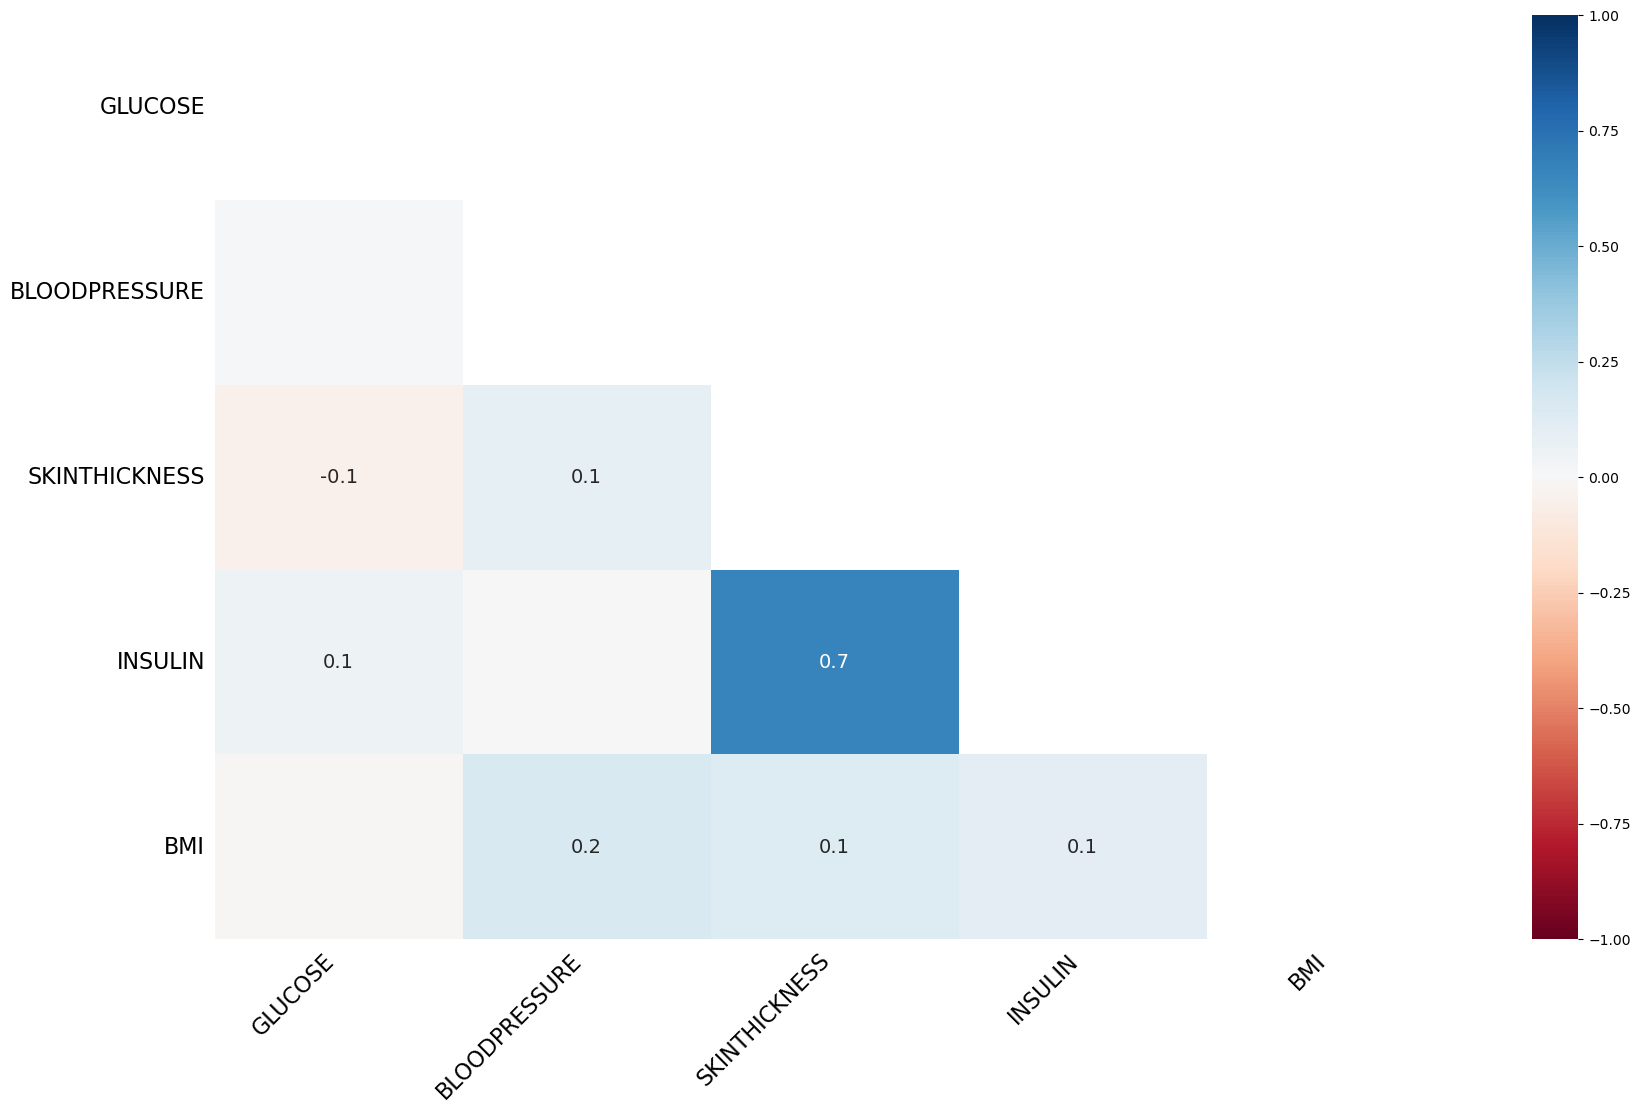

In [7]:
msno.bar(df)
plt.show(block=True)

msno.matrix(df) #değişkenlerdeki eksikliklerin birlikte çıkıp çıkmadığı ile alakalı bilgi veriyor.
plt.show(block=True)

msno.heatmap(df)
plt.show(block=True)

In [8]:
def missing_vs_target(dataframe, target, na_columns):
    temp_df = dataframe.copy()

    for col in na_columns:
        temp_df[col + '_NA_FLAG'] = np.where(temp_df[col].isnull(), 1, 0)

    na_flags = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns

    for col in na_flags:
        print(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(),
                            "Count": temp_df.groupby(col)[target].count()}), end="\n\n\n")
        
na_cols = missing_values_table(df, True)
missing_vs_target(df, "OUTCOME", na_cols)

               n_miss  ratio
INSULIN           374 48.700
SKINTHICKNESS     227 29.560
BLOODPRESSURE     121 15.760
BMI                11  1.430
GLUCOSE             5  0.650
                 TARGET_MEAN  Count
GLUCOSE_NA_FLAG                    
0                      0.349    763
1                      0.400      5


                       TARGET_MEAN  Count
BLOODPRESSURE_NA_FLAG                    
0                            0.365    647
1                            0.264    121


                       TARGET_MEAN  Count
SKINTHICKNESS_NA_FLAG                    
0                            0.333    541
1                            0.388    227


                 TARGET_MEAN  Count
INSULIN_NA_FLAG                    
0                      0.330    394
1                      0.369    374


             TARGET_MEAN  Count
BMI_NA_FLAG                    
0                  0.351    757
1                  0.182     11




# Handling Missing Values

In [9]:
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "median"}), end="\n\n\n")
for col in num_cols:
    target_summary_with_num(df,"OUTCOME", col)

         PREGNANCIES
OUTCOME             
0              2.000
1              4.000


         GLUCOSE
OUTCOME         
0        107.000
1        140.000


         BLOODPRESSURE
OUTCOME               
0               74.000
1               76.000


         SKINTHICKNESS
OUTCOME               
0               27.000
1               32.000


         INSULIN
OUTCOME         
0        102.500
1        169.500


           BMI
OUTCOME       
0       30.100
1       34.300


         DIABETESPEDIGREEFUNCTION
OUTCOME                          
0                           0.336
1                           0.449


           AGE
OUTCOME       
0       27.000
1       36.000




### Since there are differences in the median of each variable depending on outcome, I decided fill NaN values with their median depending on outcome. There are so many missing values so I can't erase them

In [10]:
for col in [col for col in num_cols if col not in "PREGNANCIES"]:
     df[col].fillna(df.groupby("OUTCOME")[col].transform("median"), inplace = True)

In [11]:
df.isnull().sum() # No more missing Values or wrong values

PREGNANCIES                 0
GLUCOSE                     0
BLOODPRESSURE               0
SKINTHICKNESS               0
INSULIN                     0
BMI                         0
DIABETESPEDIGREEFUNCTION    0
AGE                         0
OUTCOME                     0
dtype: int64

In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
PREGNANCIES,768.000,3.845,3.370,0.000,1.000,3.000,6.000,17.000
GLUCOSE,768.000,121.677,30.464,44.000,99.750,117.000,140.250,199.000
BLOODPRESSURE,768.000,75.007,9.476,60.000,68.000,74.000,80.000,122.000
SKINTHICKNESS,768.000,29.090,8.891,7.000,25.000,28.000,32.000,99.000
INSULIN,768.000,141.754,89.101,14.000,102.500,102.500,169.500,846.000
BMI,768.000,32.435,6.880,18.200,27.500,32.050,36.600,67.100
DIABETESPEDIGREEFUNCTION,768.000,0.472,0.331,0.078,0.244,0.372,0.626,2.420
AGE,768.000,33.241,11.760,21.000,24.000,29.000,41.000,81.000
OUTCOME,768.000,0.349,0.477,0.000,0.000,0.000,1.000,1.000


# Outlier Analysis

In [13]:
def outlier_thresholds(dataframe, col_name, q1=0.10, q3=0.90):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False
check_outlier(df, num_cols)

True

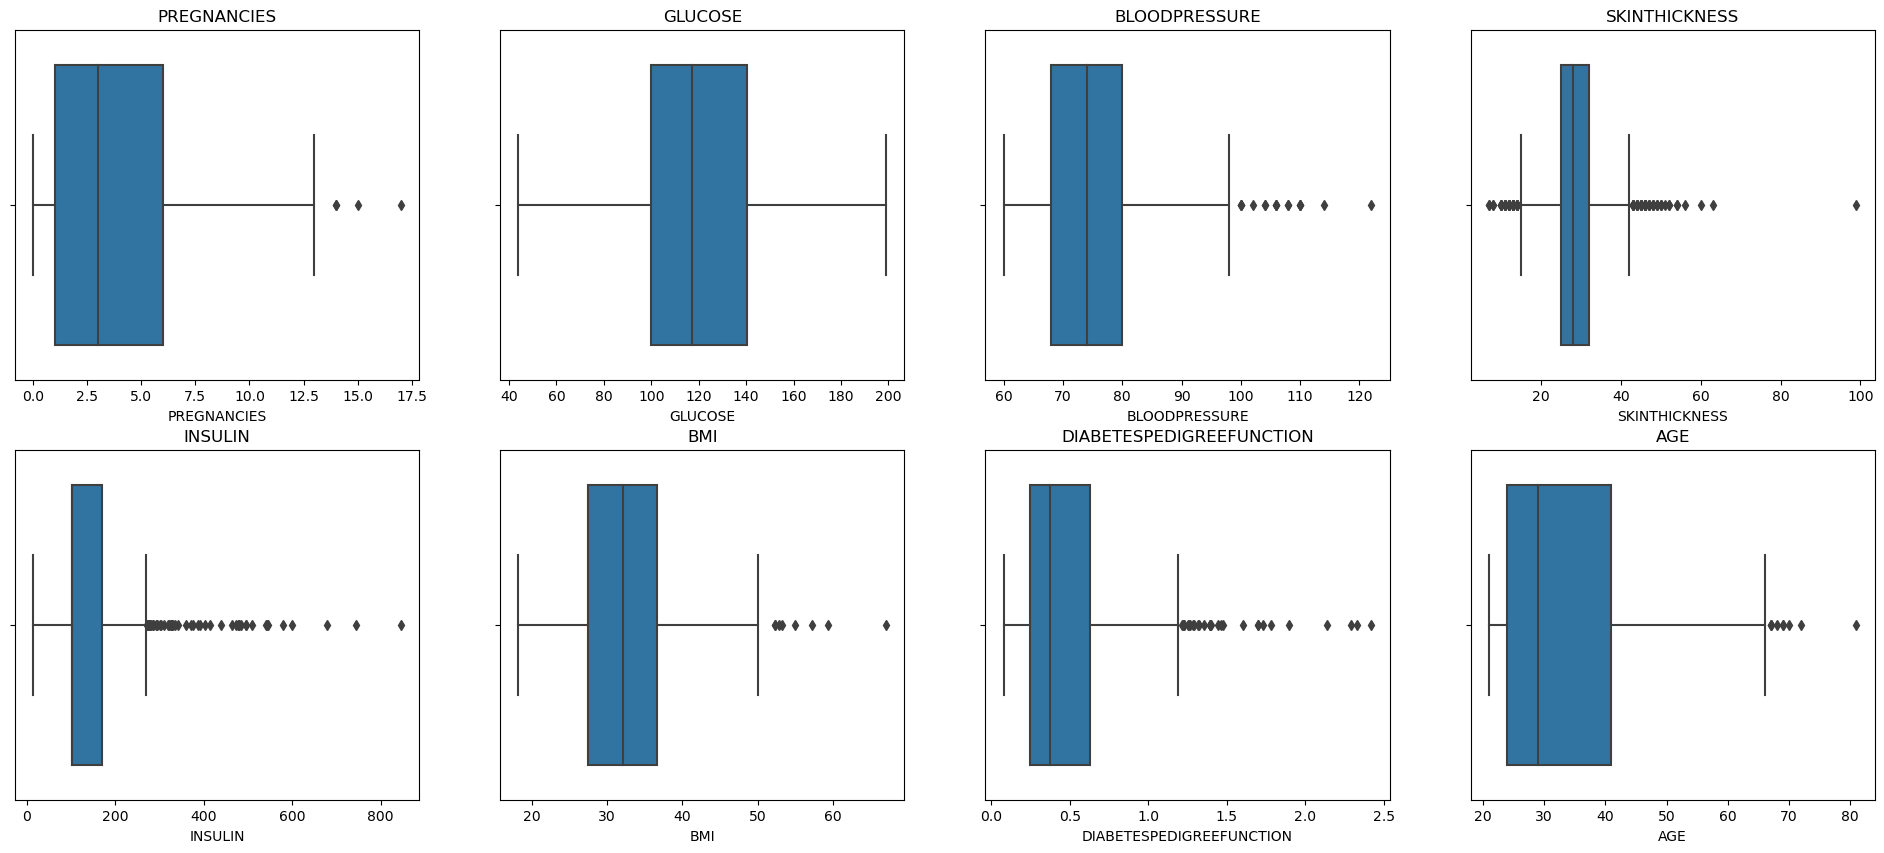

In [14]:
fig, axes = plt.subplots(2, 4, figsize=(24, 10))
for i, col in enumerate(num_cols):
    sns.boxplot(x=df[col], ax=axes[i//4, i%4])
    axes[i//4, i%4].set_title(col)
plt.show(block=True)

# Handling Outliers

In [15]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit



for col in num_cols:
    replace_with_thresholds(df,col)


In [16]:
check_outlier(df, num_cols)

False

# Categorical and Numerical Analysis

In [17]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")

    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)
def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist()
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

   OUTCOME  Ratio
0      500 65.104
1      268 34.896
##########################################


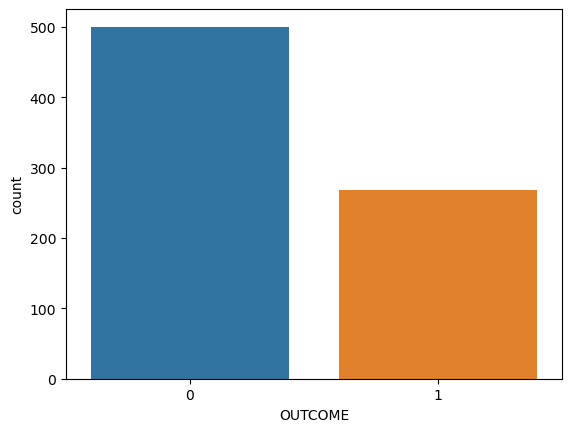

In [18]:
for col in cat_cols:
    cat_summary(df, col, plot=True)

count   768.000
mean      3.845
std       3.370
min       0.000
5%        0.000
10%       0.000
20%       1.000
30%       1.000
40%       2.000
50%       3.000
60%       4.000
70%       5.000
80%       7.000
90%       9.000
95%      10.000
99%      13.000
max      17.000
Name: PREGNANCIES, dtype: float64


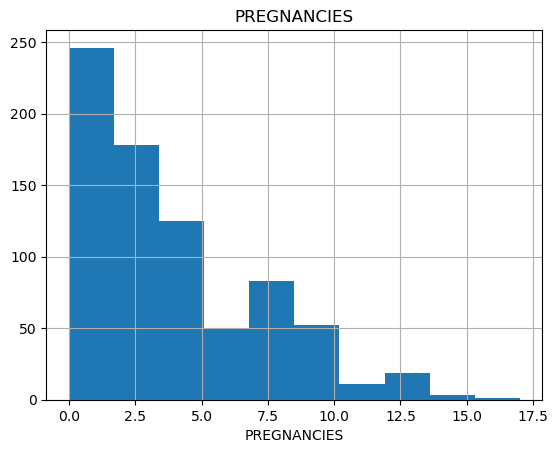

count   768.000
mean    121.677
std      30.464
min      44.000
5%       80.000
10%      86.700
20%      95.000
30%     102.100
40%     109.000
50%     117.000
60%     125.000
70%     135.000
80%     147.000
90%     167.000
95%     181.000
99%     196.000
max     199.000
Name: GLUCOSE, dtype: float64


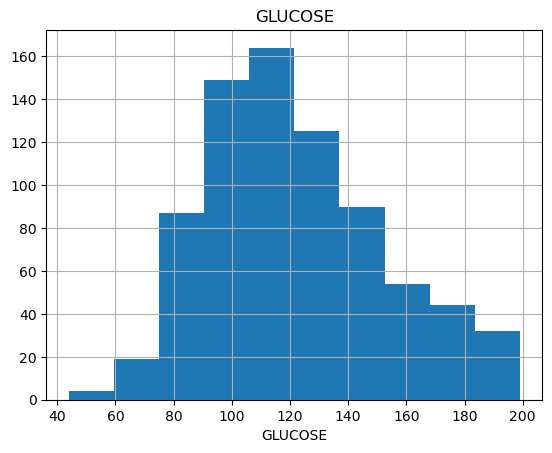

count   768.000
mean     75.007
std       9.476
min      60.000
5%       62.000
10%      64.000
20%      68.000
30%      70.000
40%      74.000
50%      74.000
60%      76.000
70%      78.000
80%      82.000
90%      88.000
95%      90.000
99%     106.000
max     122.000
Name: BLOODPRESSURE, dtype: float64


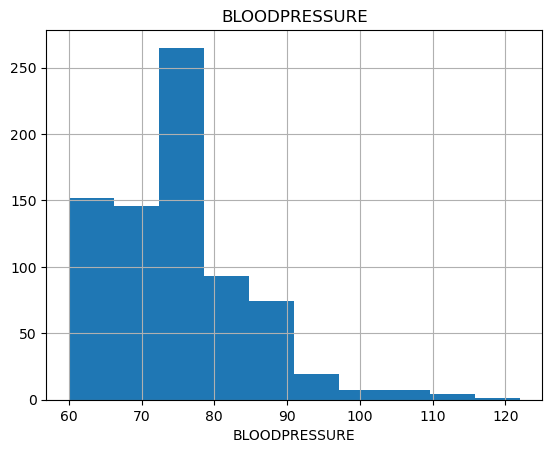

count   768.000
mean     29.056
std       8.671
min       7.000
5%       14.350
10%      18.000
20%      23.000
30%      27.000
40%      27.000
50%      28.000
60%      31.200
70%      32.000
80%      35.000
90%      40.000
95%      44.000
99%      51.330
max      73.000
Name: SKINTHICKNESS, dtype: float64


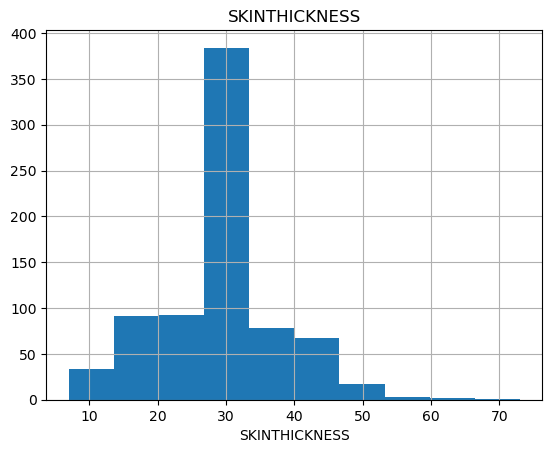

count   768.000
mean    138.840
std      75.233
min      14.000
5%       50.000
10%      67.000
20%     102.500
30%     102.500
40%     102.500
50%     102.500
60%     140.000
70%     169.500
80%     169.500
90%     210.000
95%     293.000
99%     424.500
max     424.500
Name: INSULIN, dtype: float64


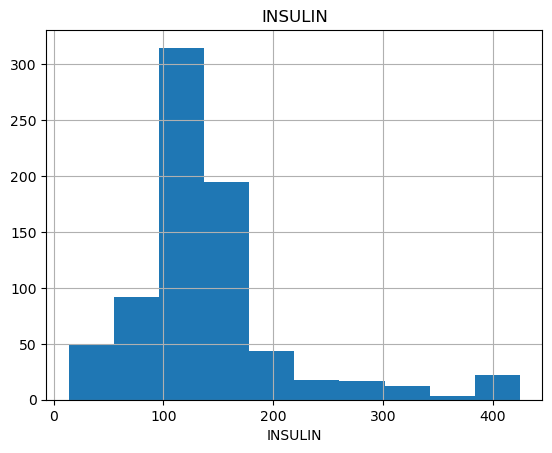

count   768.000
mean     32.435
std       6.880
min      18.200
5%       22.235
10%      24.000
20%      26.200
30%      28.500
40%      30.100
50%      32.050
60%      33.720
70%      35.490
80%      37.800
90%      41.500
95%      44.395
99%      50.759
max      67.100
Name: BMI, dtype: float64


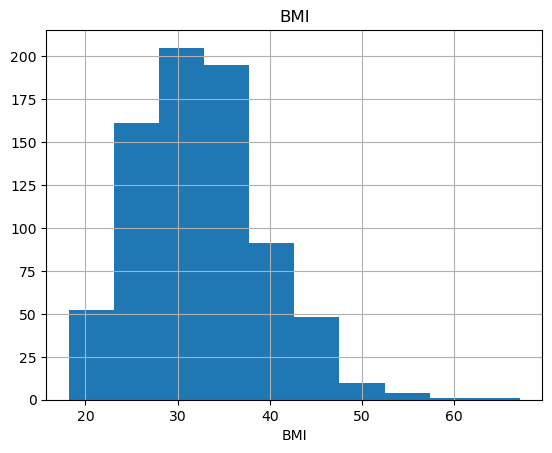

count   768.000
mean      0.470
std       0.322
min       0.078
5%        0.140
10%       0.165
20%       0.219
30%       0.259
40%       0.303
50%       0.372
60%       0.454
70%       0.564
80%       0.687
90%       0.879
95%       1.133
99%       1.698
max       1.949
Name: DIABETESPEDIGREEFUNCTION, dtype: float64


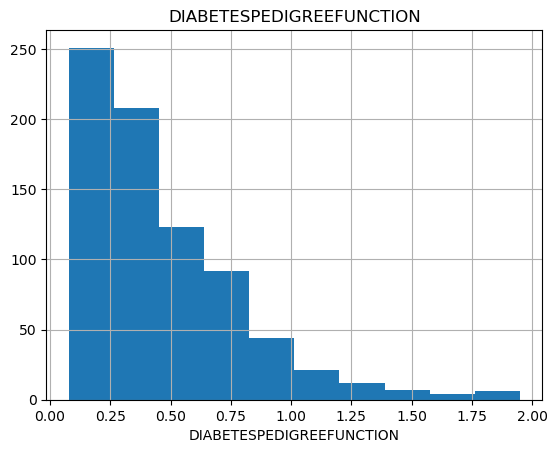

count   768.000
mean     33.241
std      11.760
min      21.000
5%       21.000
10%      22.000
20%      23.000
30%      25.000
40%      27.000
50%      29.000
60%      33.000
70%      38.000
80%      42.600
90%      51.000
95%      58.000
99%      67.000
max      81.000
Name: AGE, dtype: float64


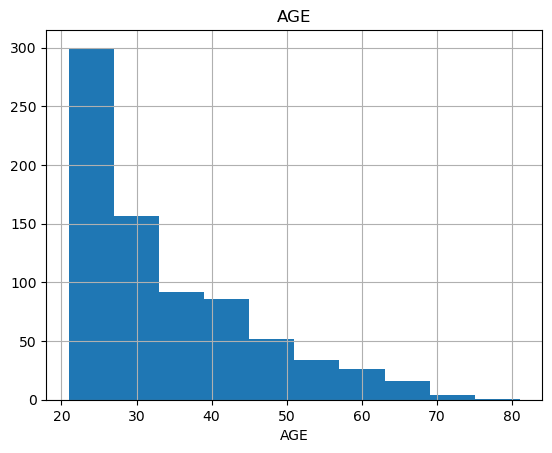

In [19]:
for col in num_cols:
    num_summary(df, col, plot=True)

In [20]:
for col in num_cols:
    target_summary_with_num(df,"OUTCOME", col)

         PREGNANCIES
OUTCOME             
0              3.298
1              4.866


         GLUCOSE
OUTCOME         
0        110.622
1        142.302


         BLOODPRESSURE
OUTCOME               
0               73.992
1               76.899


         SKINTHICKNESS
OUTCOME               
0               27.170
1               32.575


         INSULIN
OUTCOME         
0        115.518
1        182.351


           BMI
OUTCOME       
0       30.846
1       35.399


         DIABETESPEDIGREEFUNCTION
OUTCOME                          
0                           0.429
1                           0.547


           AGE
OUTCOME       
0       31.190
1       37.067




# Correlation

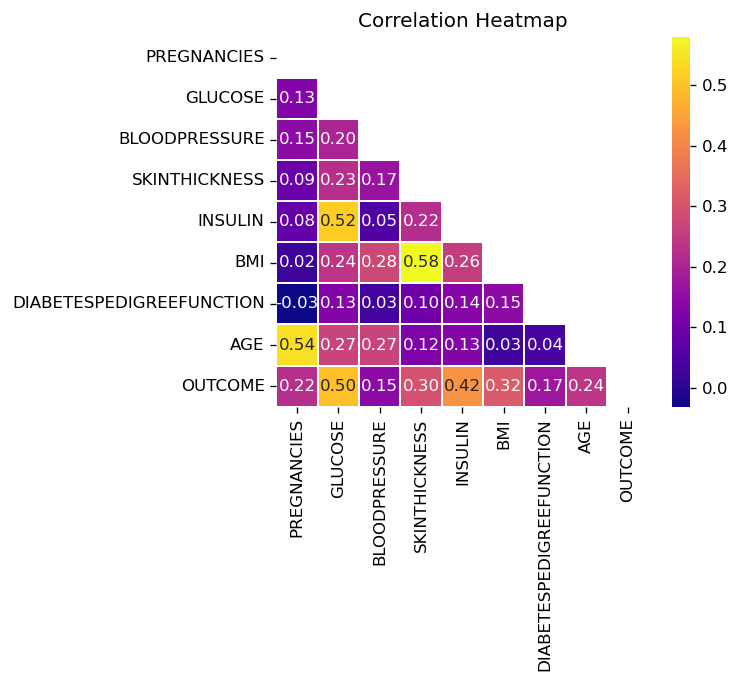

In [21]:

plt.figure(dpi = 120,figsize= (5,4))
mask = np.triu(np.ones_like(df.corr(),dtype = bool))
sns.heatmap(df.corr(),mask = mask, fmt = ".2f",annot=True,lw=1,cmap = 'plasma')
plt.yticks(rotation = 0)
plt.xticks(rotation = 90)
plt.title('Correlation Heatmap')
plt.show(block=True)


There is no high correlation, that we need take out of our model

# Feature Extraction

In [22]:
df['GLUCOSE_CAT'] = pd.cut(x = df['GLUCOSE'], bins = [-1,80,140,160,200],
                               labels = ['Hypoglecimia','Normal', 'Impaired_Glucose', 'Diabetic_Glucose'])

df['AGE_CAT']= pd.cut(df['AGE'], bins = [0, 20, 30 ,50, 81], labels=['Young','Young Adult', 'Adult', 'Old'])



In [23]:
df.loc[(df['PREGNANCIES'] == 0), 'PREGNANT_CAT']  = 'Never'
df.loc[(df['PREGNANCIES'] == 1), 'PREGNANT_CAT']  = 'One Time'
df.loc[(df['PREGNANCIES'] > 1), 'PREGNANT_CAT']   = 'Many Times'
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,GLUCOSE_CAT,AGE_CAT,PREGNANT_CAT
0,6.000,148.000,72.000,35.000,169.500,33.600,0.627,50.000,1,Impaired_Glucose,Adult,Many Times
1,1.000,85.000,66.000,29.000,102.500,26.600,0.351,31.000,0,Normal,Adult,One Time
2,8.000,183.000,64.000,32.000,169.500,23.300,0.672,32.000,1,Diabetic_Glucose,Adult,Many Times
3,1.000,89.000,66.000,23.000,94.000,28.100,0.167,21.000,0,Normal,Young Adult,One Time
4,0.000,137.000,76.000,35.000,168.000,43.100,1.949,33.000,1,Normal,Adult,Never


# Feature Scaling 
### First I'll scale numeric variables then i will generate new variables from scaled variables

In [24]:
# scaler = StandardScaler()
# df[num_cols] = scaler.fit_transform(df[num_cols])



rs= RobustScaler()
df[num_cols]= rs.fit_transform(df[num_cols])
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,GLUCOSE_CAT,AGE_CAT,PREGNANT_CAT
0,0.600,0.765,-0.167,1.000,1.000,0.170,0.665,1.235,1,Impaired_Glucose,Adult,Many Times
1,-0.400,-0.790,-0.667,0.143,0.000,-0.599,-0.056,0.118,0,Normal,Adult,One Time
2,1.000,1.630,-0.833,0.571,1.000,-0.962,0.783,0.176,1,Diabetic_Glucose,Adult,Many Times
3,-0.400,-0.691,-0.667,-0.714,-0.127,-0.434,-0.537,-0.471,0,Normal,Young Adult,One Time
4,-0.600,0.494,0.167,1.000,0.978,1.214,4.122,0.235,1,Normal,Adult,Never


In [25]:
df["AGE*BMI_NEW"] = df["AGE"] * df["BMI"]

df["NEW_GLUCOSE*INSULIN"] = df["GLUCOSE"] * df["INSULIN"]
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,GLUCOSE_CAT,AGE_CAT,PREGNANT_CAT,AGE*BMI_NEW,NEW_GLUCOSE*INSULIN
0,0.600,0.765,-0.167,1.000,1.000,0.170,0.665,1.235,1,Impaired_Glucose,Adult,Many Times,0.210,0.765
1,-0.400,-0.790,-0.667,0.143,0.000,-0.599,-0.056,0.118,0,Normal,Adult,One Time,-0.070,-0.000
2,1.000,1.630,-0.833,0.571,1.000,-0.962,0.783,0.176,1,Diabetic_Glucose,Adult,Many Times,-0.170,1.630
3,-0.400,-0.691,-0.667,-0.714,-0.127,-0.434,-0.537,-0.471,0,Normal,Young Adult,One Time,0.204,0.088
4,-0.600,0.494,0.167,1.000,0.978,1.214,4.122,0.235,1,Normal,Adult,Never,0.286,0.483


In [26]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 14
cat_cols: 4
num_cols: 10
cat_but_car: 0
num_but_cat: 3


New variables also have to be scaled

In [27]:
rs= RobustScaler()
df[num_cols]= rs.fit_transform(df[num_cols])
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,GLUCOSE_CAT,AGE_CAT,PREGNANT_CAT,AGE*BMI_NEW,NEW_GLUCOSE*INSULIN
0,0.600,0.765,-0.167,1.000,1.000,0.170,0.665,1.235,1,Impaired_Glucose,Adult,Many Times,0.607,1.408
1,-0.400,-0.790,-0.667,0.143,0.000,-0.599,-0.056,0.118,0,Normal,Adult,One Time,-0.263,-0.032
2,1.000,1.630,-0.833,0.571,1.000,-0.962,0.783,0.176,1,Diabetic_Glucose,Adult,Many Times,-0.571,3.034
3,-0.400,-0.691,-0.667,-0.714,-0.127,-0.434,-0.537,-0.471,0,Normal,Young Adult,One Time,0.588,0.133
4,-0.600,0.494,0.167,1.000,0.978,1.214,4.122,0.235,1,Normal,Adult,Never,0.840,0.876


In [28]:
for col in cat_cols:
    cat_summary(df, col, plot=False)

            PREGNANT_CAT  Ratio
Many Times           522 67.969
One Time             135 17.578
Never                111 14.453
##########################################
   OUTCOME  Ratio
0      500 65.104
1      268 34.896
##########################################
                  GLUCOSE_CAT  Ratio
Normal                    534 69.531
Diabetic_Glucose          101 13.151
Impaired_Glucose           91 11.849
Hypoglecimia               42  5.469
##########################################
             AGE_CAT  Ratio
Young Adult      417 54.297
Adult            270 35.156
Old               81 10.547
Young              0  0.000
##########################################


In [29]:
for col in cat_cols:
    target_summary_with_cat(df, "OUTCOME", col)

              TARGET_MEAN
PREGNANT_CAT             
Many Times          0.385
Never               0.342
One Time            0.215


         TARGET_MEAN
OUTCOME             
0              0.000
1              1.000


                  TARGET_MEAN
GLUCOSE_CAT                  
Hypoglecimia            0.048
Normal                  0.251
Impaired_Glucose        0.538
Diabetic_Glucose        0.822


             TARGET_MEAN
AGE_CAT                 
Young                NaN
Young Adult        0.216
Adult              0.519
Old                0.469




# Label Encoding

In [30]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=True, dummy_na =False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first, dummy_na=dummy_na)
    return dataframe
ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]
df = one_hot_encoder(df, ohe_cols)
df.head()


,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,AGE*BMI_NEW,NEW_GLUCOSE*INSULIN,GLUCOSE_CAT_Normal,GLUCOSE_CAT_Impaired_Glucose,GLUCOSE_CAT_Diabetic_Glucose,AGE_CAT_Young Adult,AGE_CAT_Adult,AGE_CAT_Old,PREGNANT_CAT_Never,PREGNANT_CAT_One Time
0,0.600,0.765,-0.167,1.000,1.000,0.170,0.665,1.235,1,0.607,1.408,0,1,0,0,1,0,0,0
1,-0.400,-0.790,-0.667,0.143,0.000,-0.599,-0.056,0.118,0,-0.263,-0.032,1,0,0,0,1,0,0,1
2,1.000,1.630,-0.833,0.571,1.000,-0.962,0.783,0.176,1,-0.571,3.034,0,0,1,0,1,0,0,0
3,-0.400,-0.691,-0.667,-0.714,-0.127,-0.434,-0.537,-0.471,0,0.588,0.133,1,0,0,1,0,0,0,1
4,-0.600,0.494,0.167,1.000,0.978,1.214,4.122,0.235,1,0.840,0.876,1,0,0,0,1,0,1,0


# ML Model

In [31]:
y = df["OUTCOME"]
X = df.drop(["OUTCOME"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy_score(y_pred, y_test)

0.8961038961038961

Pretty damn good :) for my first model 

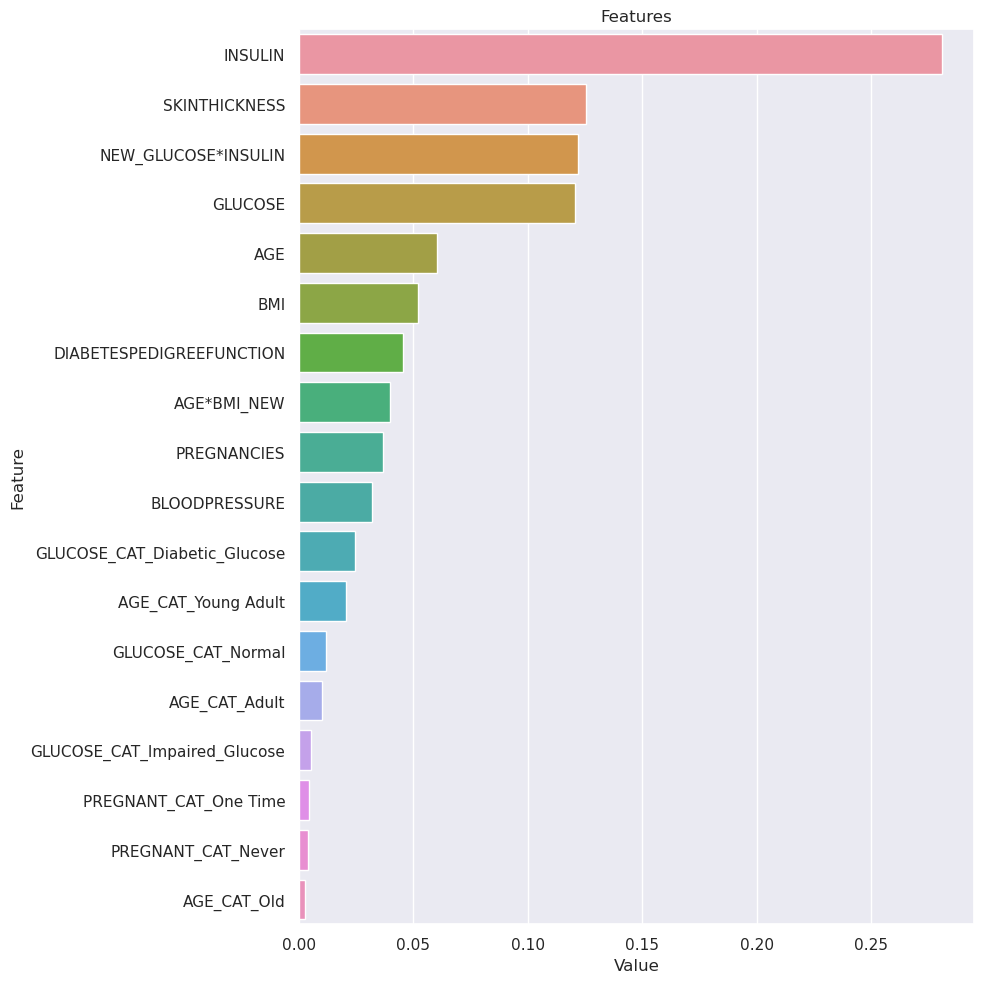

In [32]:
def plot_importance(model, features, num=len(X)):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize = (10, 10))
    sns.set(font_scale = 1)
    sns.barplot(x = "Value", y = "Feature", data = feature_imp.sort_values(by = "Value", ascending = False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show(block=True)

plot_importance(rf_model, X_train)

Thank you for your suggestions and comments.  

My linkedin profile: https://www.linkedin.com/in/sefercan-apaydin/  

My Github profile: https://github.com/sefercanapaydin  

References: https://www.miuul.com/